In [21]:
import numpy as np
import matplotlib.pyplot as plt
from datasets.tensor_storage import TensorStorage
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

In [22]:
experiment_id = "deepinfomax_20241218_041336"

In [23]:
store = TensorStorage(f"storages/{experiment_id}")

In [24]:
metadata_df = store.load_metadata_table()

In [25]:
metadata_df.head()

,split,label,batch_idx,tensor_idx
0,train,1,0,0
1,train,1,0,1
2,train,0,0,2
3,train,7,0,3
4,train,5,0,4


In [26]:
store[0].shape

(64,)

In [27]:
def load_embeddings_and_metadata(store):
    metadata_df = store.load_metadata_table()
    
    # Load all embeddings into memory
    embeddings = []
    for i in tqdm(range(len(store)), desc="Loading embeddings"):
        embeddings.append(store[i])
    
    return np.array(embeddings), metadata_df

In [28]:
def plot_embeddings(embeddings, metadata_df, split='train'):
    """Create PCA visualization of embeddings."""
    # CIFAR-10 class names
    class_names = [
        'airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck'
    ]
    
    # Filter by split
    split_mask = metadata_df['split'] == split
    split_embeddings = embeddings[split_mask]
    split_labels = metadata_df[split_mask]['label'].values
    
    # Compute PCA
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(split_embeddings)
    
    # Set up the plot
    plt.figure(figsize=(12, 8))
    
    # Use a colorful and visually appealing palette
    palette = sns.color_palette('husl', n_colors=len(class_names))
    
    # Plot each class
    for label in range(len(class_names)):
        mask = split_labels == label
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            c=[palette[label]],
            label=class_names[label],
            alpha=0.6,
            s=50
        )
    
    # Customize the plot
    plt.xlabel(f'First Principal Component\n(Explained variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Second Principal Component\n(Explained variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.title(f'CIFAR-10 {split.capitalize()} Set Embeddings\nPCA Visualization', pad=20)
    
    # Add legend with two columns
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)
    
    # Add grid and style
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    return plt.gcf()

In [29]:
embeddings, metadata_df = load_embeddings_and_metadata(store)

Loading embeddings: 100%|██████████| 54912/54912 [00:00<00:00, 327842.60it/s]


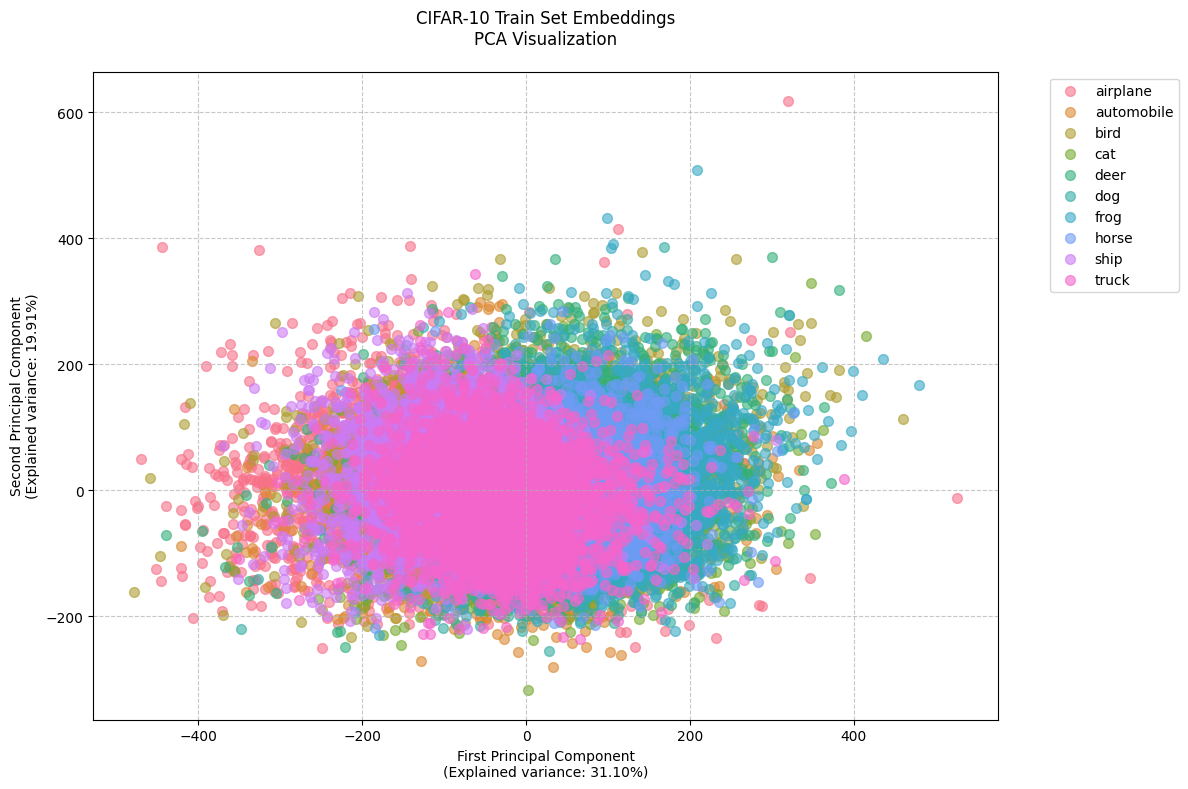

In [30]:
fig_train = plot_embeddings(embeddings, metadata_df, split='train')
